<a href="https://colab.research.google.com/github/taejjing/kaggle_iMet/blob/master/make_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
DATA_DIR = '/content/imet/'

In [0]:
! mkdir ~/.kaggle
! cp /gdrive/'My Drive'/'Colab Notebooks'/kaggle/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! mkdir {DATA_DIR}

In [0]:
! kaggle competitions download -c imet-2019-fgvc6 -p {DATA_DIR}
! ls -l {DATA_DIR}

In [0]:
!unzip {DATA_DIR}/test.zip -d {DATA_DIR}/test/
!unzip {DATA_DIR}/train.zip -d {DATA_DIR}/train/
!unzip {DATA_DIR}/train.csv.zip -d {DATA_DIR}

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
K.image_data_format()

Using TensorFlow backend.


'channels_last'

In [0]:
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
from PIL import ImageOps, ImageFilter
from tqdm import tqdm
import os

In [0]:
df_train = pd.read_csv(DATA_DIR + 'train.csv')
df_label = pd.read_csv(DATA_DIR + 'labels.csv')

In [5]:
df_train.head()

,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


In [155]:
df_train.iloc[47121]

id               8c386c9831f35a62.png
attribute_ids                189 1059
Name: 56558, dtype: object

In [22]:
df_train.iloc[0, 1]

'147 616 813'

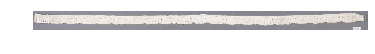

In [169]:
img = PIL.Image.open(f'{DATA_DIR}/train/77a112100842df43.png')
plt.imshow(img)
plt.axis('off')
plt.show()

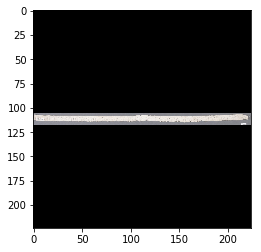

In [174]:
plt.imshow(resize_with_pad(img, 224))

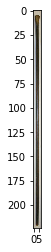

In [126]:
plt.imshow(resized)

In [0]:
img1 = np.array(PIL.Image.open(f'{DATA_DIR}/train/1001614cb89646ee.png').resize((224, 224)))
img2 = np.array(PIL.Image.open(f'{DATA_DIR}/train/1000483014d91860.png').resize((224, 224)))

In [0]:
img1 = img1.reshape(1, 224, 224, 3)
img2 = img2.reshape(1, 224, 224, 3)

In [109]:
np.append(img1, img2, axis=0).shape

(448, 224, 3)

In [32]:
df_label.iloc[776]

attribute_id                  776
attribute_name    tag::landscapes
Name: 776, dtype: object

In [0]:
df_train['min'] = df_train.loc[:, 'attribute_ids'].map(lambda x : x.split(' ')[0])

In [53]:
df_train.loc[df_train['min'] >= 398].shape

(15692, 3)

In [0]:
df_train['id']  = df_train.loc[:, 'id'].map(lambda x: str(x) + str('.png'))

In [9]:
df_train.head()

,id,attribute_ids
0,1000483014d91860.png,147 616 813
1,1000fe2e667721fe.png,51 616 734 813
2,1001614cb89646ee.png,776
3,10041eb49b297c08.png,51 671 698 813 1092
4,100501c227f8beea.png,13 404 492 903 1093


In [0]:
def resize_with_pad(img, sizeToWant):
    
    img_width = img.size[0]
    img_height = img.size[1]
    
    if img_width > img_height :
        h_resized = int(img_height*sizeToWant / img_width)
        resized = img.resize((sizeToWant, h_resized))

        pad_height = sizeToWant - h_resized
        padding = (0, pad_height//2, 0, pad_height-(pad_height//2))

        output_img = ImageOps.expand(resized, padding)
    
    elif img_width < img_height :
        w_resized = int(img_width * sizeToWant / img_height)
        resized = img.resize((w_resized, sizeToWant))

        pad_width = sizeToWant - w_resized
        padding = (pad_width//2, 0, pad_width-(pad_width//2), 0)

        output_img = ImageOps.expand(resized, padding)
        
    else :
        output_img = img.resize((sizeToWant,sizeToWant))
    
    return output_img

In [0]:
img_width, img_height = 224, 224

nb_train_samples = len(df_train)

nb_validation_samples = len(os.listdir(DATA_DIR + 'test'))

batch_size = 64

In [0]:
def data_preprocessing() :
    sizeToWant = 224
    
    nb_train_samples = len(df_train)
    
    is_first_file = True
    for file in tqdm(df_train.iloc[:nb_train_samples, 0]):
        img_file = PIL.Image.open(f'{DATA_DIR}/train/{file}')
        padded_img = np.array(resize_with_pad(img_file, sizeToWant))
        padded_img = padded_img.reshape(1, sizeToWant, sizeToWant, 3)
        
        if is_first_file :
            global img_chunk
            img_chunk = padded_img
            is_first_file = False
        else :
            img_chunk = np.append(img_chunk, padded_img, axis=0)

    np.savez(DATA_PATH + 'train.npz')

In [0]:
def data_preprocessing_test() :
    sizeToWant = 224
    
    test_list = os.listdir(DATA_DIR + 'test')
    nb_test_samples = len(test_list)
    
    is_first_file = True
    for file in tqdm(test_list):
        img_file = PIL.Image.open(f'{DATA_DIR}/test/{file}')
        padded_img = np.array(resize_with_pad(img_file, sizeToWant))
        padded_img = padded_img.reshape(1, sizeToWant, sizeToWant, 3)
        
        if is_first_file :
            global img_chunk
            img_chunk = padded_img
            is_first_file = False
        else :
            img_chunk = np.append(img_chunk, padded_img, axis=0)

    np.savez(DATA_DIR + 'test.npz', img_chunk)

In [0]:
np.savez(DATA_DIR + 'test.npz', img_chunk)

In [14]:
data_preprocessing()

  4%|▎         | 3950/109237 [06:54<5:56:01,  4.93it/s]

KeyboardInterrupt: ignored

In [17]:
data_preprocessing_test()


100%|██████████| 7443/7443 [24:14<00:00,  2.68it/s]


NameError: ignored

In [22]:
! gsutil cp {DATA_DIR}test.npz gs://tj-kaggle/LANL/

Copying file:///content/imet/test.npz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/1.0 GiB.                                      
